# Explainable recommendation
## Attentive Multitask Collaborative Filtering (AMCF) model

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_amcf import get_data, item_to_genre


In [2]:
# load model
model = torch.load('AMCF_model_1231.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

AMCF(
  (user_emb): Embedding(34550, 128)
  (item_emb): Embedding(1666, 128)
  (asp_emb): Aspect_emb()
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=12, bias=True)
  )
  (pdist): PairwiseDistance()
)

In [3]:
# load fund data
import pickle
fund = pickle.load(open('plot/fund_data_1231.pkl', 'rb'))
user_dict = pickle.load(open('plot/user_dict.pkl', 'rb'))
fund_dict = pickle.load(open('plot/fund_dict.pkl', 'rb'))


In [4]:
from recommend import predict_rate
from evaluation import Evaluation

In [75]:
user_list, item_list = list(range(100)), fund['fid'].unique().tolist()
# recommendation
pred = predict_rate(user_list, item_list, model, fund, user_dict, fund_dict)
pred_df = pd.DataFrame(list(pred.items()), columns=['User', 'Pred_funds'])
# evaluation
evaluation_path = '/tmp2/jeding/Esun_online_data/evaluation_data/evaluation_df_2018-12-31.csv'
evaluation = Evaluation('2018-12-31', evaluation_path, pred)
answer = pd.DataFrame(list(evaluation.answer(evaluation_path).items()), columns=['User', 'Funds'])
answer['pred_funds'] = pred_df['Pred_funds']
answer.loc[:5]

100%|██████████| 100/100 [00:00<00:00, 107.57it/s]


,User,Funds,pred_funds
0,++1QLn8bCFzxWN8vQYBuRg==,"[NN18, NN18]","[AF37, NN47, AG52, AG25, NN18]"
1,++2WLG2lyrgp9jhLkCFEKg==,"[WW06, 2509, AG74]","[AG25, AG74, AA39, WW06, 2509]"
2,++3bvnatF8Ie6ZC/bs3rcA==,"[1204, 6017, 6216, 1204, 6216, 6017]","[AI45, ED64, FE41, 6017, 6216]"
3,++7FzPdZNv2Gw99EJ/ZUUg==,[CC03],"[OB02, AH02, MM04, AG25, CC03]"
4,++GMXRROXNCZtHYs3ymfyg==,"[AG24, AG48, AG30]","[NN18, 1207, AG30, AG48, AG24]"
5,++GZwPiWQxnKY2tXthUm6Q==,[KK32],"[ED64, UF58, CC88, AG25, KK32]"


In [66]:
list(fund_dict.keys())[list(fund_dict.values()).index('NN18')]

1419

### Plot user's overall & specific preference

In [46]:
# get user overall preference of each aspects
users = torch.tensor(range(100), dtype=torch.long).to(device)
u_pred = model.predict_pref(users)
print(u_pred[0], u_pred.shape)

tensor([ 0.0452,  0.0304,  0.0270, -0.0334,  0.0797,  0.0377, -0.0156, -0.2870,
         0.3589,  0.0410,  0.0258,  0.0184], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([100, 12])


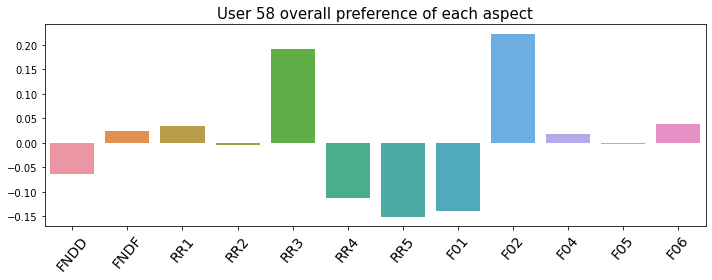

In [73]:
def plot_upref(uid, u_pred):
    df = pd.DataFrame(u_pred[0].cpu().detach().numpy())
    aspects = ['FNDD', 'FNDF',
       'RR1', 'RR2', 'RR3', 'RR4', 'RR5',
       'F01', 'F02', 'F04', 'F05', 'F06']
    plt.figure(figsize=(10,4))
    sns.barplot(x=aspects, y=u_pred[uid].cpu().detach().numpy(), data=df)
    plt.title('User '+str(uid)+' overall preference of each aspect', fontsize=15)
    plt.xticks(rotation=50, fontsize=14)
    plt.tight_layout()
    plt.savefig('plot/overall_pref_bar.png')

plot_upref(58, u_pred)

In [9]:
fund.columns

Index(['fid', 'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5', 'invest_type_F01',
       'invest_type_F02', 'invest_type_F03', 'invest_type_F05',
       'invest_type_F06'],
      dtype='object')

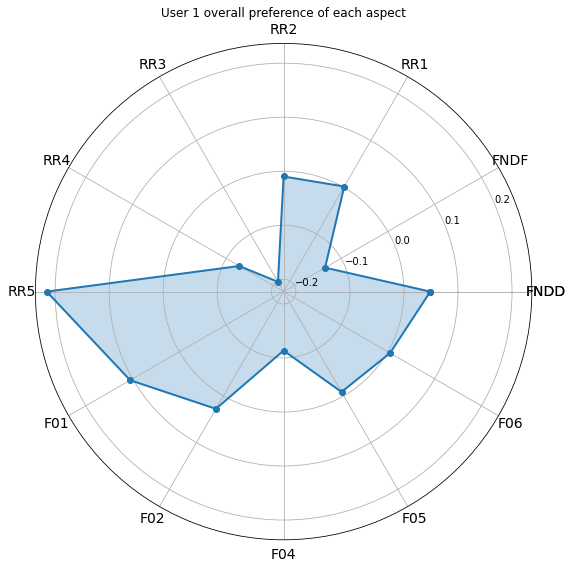

In [19]:
def plot_upref_radar(uid, u_pred):
    stats = u_pred[uid].cpu().detach().numpy()
    aspects = np.array(['FNDD', 'FNDF',
       #'AUD', 'CAD', 'CHF', 'CNY', 'EUR', 'GBP', 'HKD', 'JPY','NZD', 'SEK', 'SGD', 'TWD','USD', 'ZAR',
       'RR1', 'RR2', 'RR3', 'RR4', 'RR5',
       'F01', 'F02', 'F04', 'F05', 'F06'])
    
    angles=np.linspace(0, 2*np.pi, len(aspects), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    aspects=np.concatenate((aspects,[aspects[0]]))
    ax.set_thetagrids(angles * 180/np.pi, aspects, fontsize=14)
    ax.set_title('User '+str(uid)+' overall preference of each aspect')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig('overall_pref_radar.png')

plot_upref_radar(1, u_pred)

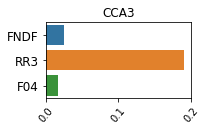

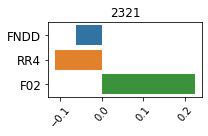

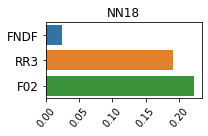

In [69]:

def plot_ui_spec_pref(uid, iid, u_pred):
    fund_id = fund_dict[iid]
    # get user specific preference on item j of each aspects
    df = pd.DataFrame(u_pred[uid].cpu().detach().numpy())

    aspects = np.array(['FNDD', 'FNDF',
       'RR1', 'RR2', 'RR3', 'RR4', 'RR5',
       'F01', 'F02', 'F04', 'F05', 'F06'])

    item_feature = np.array(fund[fund['fid']==iid])[0] # multi-hot value
    item_feature = list(item_feature[1:])

    spec_pref = u_pred[uid].cpu().detach().numpy()*item_feature
    asp_index = np.nonzero(spec_pref!=0)[0]
    spec_pref = (spec_pref[spec_pref!=0])

    plt.figure(figsize=(3,2))
    # sns.barplot(x=spec_pref, y=aspects, orient='h') # y=aspects
    sns.barplot(x=spec_pref, y=aspects[asp_index], orient='h') # y=aspects
    plt.title(fund_id)
    plt.xticks(rotation=50)
    plt.yticks(fontsize=12)
    # plt.axhline(0, color='gray')
    plt.tight_layout()
    plt.savefig('plot/spec_pref_'+fund_id+'.png')


plot_ui_spec_pref(58, 1175, u_pred)
plot_ui_spec_pref(58, 198, u_pred)
plot_ui_spec_pref(58, 1419, u_pred)